# Imports

In [1]:
!pip -q install ktrain requests

     |████████████████████████████████| 25.3 MB 2.9 MB/s 
     |████████████████████████████████| 981 kB 50.0 MB/s 
     |████████████████████████████████| 263 kB 53.1 MB/s 
     |████████████████████████████████| 3.8 MB 49.4 MB/s 
     |████████████████████████████████| 1.3 MB 21.3 MB/s 
     |████████████████████████████████| 468 kB 49.7 MB/s 
     |████████████████████████████████| 880 kB 49.0 MB/s 
     |████████████████████████████████| 182 kB 51.7 MB/s 
     |████████████████████████████████| 7.6 MB 49.5 MB/s 


In [2]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 8.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
import pandas as pd
import numpy as np
import json
import pickle as pkl

import yaml

import ktrain 
from ktrain import text as txt

import uuid

import re
import spacy
from spacy.lang.pt.examples import sentences 
from spacy.training import offsets_to_biluo_tags



# Utils

In [4]:
nlp = spacy.load('pt_core_news_sm')
entidadesExtratoContrato = ['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato'
                            ]

def get_token_for_char(doc, char_idx):
    for i, token in enumerate(doc):
        if  token.idx <= char_idx <= token.idx+len(token.text):
            return token.idx,len(token.text)

def get_span(text, label, ent):
    span = {'label':label, 'start':0, 'end':0}
    doc = nlp(text)
    if ent in doc.text:
        t1 = get_token_for_char(doc,doc.text.index(ent))
        t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
        span['start'] = t1[0]
        span['end'] = t2[0]+t2[1]
        #print(doc.text[span['start']:span['end']])
    return span

def entity_to_span(text, value, key):
    span_list = []
    e=0
    text = re.sub('\n', ' ', text)
    for entity in value:
        doc = nlp(text)
        ent = re.sub('\n', ' ', entity.replace(r'\n', '\n'))
        #print(text, '\n\t\t',key,'->', ent,'\n\n')
        #print(ent)
        span = {'label':key, 'start':0, 'end':0}
        #ent = entity[0]
        if ent in doc.text:
            #print(ent)
            #print(doc.text)
            t1 = get_token_for_char(doc,doc.text.index(ent))
            #print(doc.text.index(ent)+len(ent)-1)
            t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
            span['start'] = t1[0]
            span['end'] = t2[0]+t2[1]
            #print(doc.text[span['start']:span['end']])
            if(span['start']!=0 and span['end']!=0):
                span_list.append((span['start']+e,span['end']+e,span['label']))
            e+=span['end']
            text = text[span['end']:]
    return span_list

# testando prediçoes coflitantes
# '(948, 958, 'data_assinatura_contrato')' and '(907, 1101, 'vigencia_contrato')'
def ajust_preds(text,preds):
    #print(preds)
    new_preds = preds
    text = re.sub('\n', ' ', text)
    for p1 in preds:
        for p2 in preds:
            #print(p1,p2)
            if ((p2[0]<=p1[0] and p1[0]<=p2[1]) or (p2[0]<=p1[1] and p1[1]<=p2[1])) and p1 != p2:
                # print('p1:', p1)
                # print('p2:', p2)
                ent = text[p1[0]:p1[1]]
                label = p1[2]
                #print(ent)
                text_aux = text[p2[1]:]
                idx0 = p2[0]
                idx1 = p2[1]
                flag = 0
                # Procura no texto por outra ocorrencia
                while flag == 0:
                    flag = 1
                    span = get_span(text_aux,label,ent)
                    #print(span)
                    for p3 in preds:
                        # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                        if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                            #print('p3[0]:',p3[0])
                            #print('p3[1]:',p3[1])
                            flag = 0
                            text_aux = text[p3[1]:]
                            #print(text_aux)
                            idx0 = p3[0]
                            idx1 = p3[1]
                            # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                            # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                            #break
                # se achou um acorrenciaque não faz parte de outra entidade, remove sua ocorrencia anterior e adiciona a nova
                if(span['start']!=0 and span['end']!=0):
                    #print('trocou p1: ', p1)
                    #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                    preds.remove(p1)
                    preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                    return preds,0
                # se não achou nenhuma nova ocorrencia, devemos retirar a ocorrencia de maior tamanho, pois é provavel que essa esteja afetando a ocorrencia menor
                else:
                    #print('removeu p1: ', p1)
                    preds.remove(p1)
                    return preds,0
                    # if idx1-idx0 >= p1[1]-p1[0]:
                    #     #print('removeu p2')
                    #     preds.remove(p2)
                    # else:
                    #     #print('removeu p1')
    return preds,1

def rec_ajust_preds(text,preds):
    preds, teste = ajust_preds(text,preds)
    while teste!=1:
      preds, teste = ajust_preds(text,preds)
    return preds

def get_list_spans(text,labels_dict):
    #labels_dict = yaml.safe_load(labels_dict)
    lista = []
    for key, value in labels_dict.items():
        if key not in entidadesExtratoContrato:
          continue
        #pred = ajust_preds(text,entity_to_span(text,value,key))
        pred = entity_to_span(text,value,key)
        for i in pred:
            lista.append(i)
    #print(lista)
    return rec_ajust_preds(text,lista)

In [5]:
def tokenize(texto,labels):
    if isinstance(labels, str):
        labels = yaml.safe_load(re.sub('\n', ' ', labels.replace(r'\n', '\n')))
        
    preds = get_list_spans(texto,labels)

    nlp = spacy.load('pt_core_news_sm')
    conll=''

    text = re.sub('\n', ' ', texto)
    doc = nlp(text)

    tags = offsets_to_biluo_tags(doc, preds)

    for i in range(len(doc)):
        if tags[i][0] == 'U':
            conll += doc[i].text + ' ' + 'B' + tags[i][1:] + '\n'
        elif tags[i][0] == 'L':
            conll += doc[i].text + ' ' + 'I' + tags[i][1:] + '\n'
        else:
            conll += doc[i].text + ' ' + tags[i] + '\n'
          
    conll+='\n'

    return conll

In [6]:
# Função que gera string no formato Conll a partir das predições dos modelos
def get_conll_conc(pred):
  conll_conc = ""
  for i, tupla in enumerate(pred):
      txt,ent = tupla[0],tupla[1]
      if ent =='O':
        conll_conc += txt + ' O\n'
      else:
        if(i!=0 and pred[i-1][1]==ent):
          conll_conc += txt + ' '+ ent +'\n'
        else:
          conll_conc += txt + ' '+ ent +'\n'

  return conll_conc+'\n'

In [7]:
# função que trasnforma as prediçõe dos modelos ktrain em dicionarios para facilitar a comparação sem depender de tokenizações
def get_entities_from_prediction(predictions):
    lista = []
    cont = 0
    for pred in predictions:
        ents_dit = {}
        i=0
        while (i < len(pred)):
            txt,ent = pred[i][0],pred[i][1]
            if ent !='O':
                aux_txt = txt
                while(len(pred) > i+1 and pred[i+1][1] != 'O'):
                    if(pred[i+1][1][2:] == ent[2:]):
                        aux_txt += ' ' + pred[i+1][0]
                        i+=1
                    else:
                        break
                if(ent[2:] in ents_dit):
                    ents_dit[ent[2:]].append(aux_txt)
                else:
                    ents_dit[ent[2:]] = [aux_txt]
            i+=1
        lista.append(ents_dit)
        cont+=1
    return lista

In [8]:
# função que compara similaridade entre strings
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [9]:
# função que retorna concordancias e discordancias entre as predições dos modelo
# funciona a partir da comparação da strings de cada entidade predita
# Casos a maioria das entidades preditas pelos modelos aprensete similarideade mairo ou igula a 90% consideramos como um caso de concordancia
def get_agreements(predictions,samples) :
    entidadesExtratoContrato = ['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato'
                            ]

    # samples = [[id1,text1,pred1],[id2,text2,pred2]....]
    agreements =[]
    disagreements =[]
    entities = [get_entities_from_prediction(prediction) for prediction in predictions]

    for i in range(len(samples)):
        veredicts = {}
        majority    = 0
        majority_id = 0

        for j in range(len(predictions)):
            veredicts[j]=0
            for k in range(j,len(predictions)):
                if (entities[j][i] == {} and entities[k][i] == {}):
                    continue
                cont=0
                comp_pred = max(len(entities[j][i]),len(entities[k][i]))
                for l in entidadesExtratoContrato:
                  if l in entities[j][i] and l in entities[k][i]:
                    if(similar(entities[j][i][l],  entities[k][i][l]) >= 0.9):
                      cont+=1
                if cont>=comp_pred/2:
                  veredicts[j]+=1

        for v in veredicts:        
            if veredicts[v] > majority :
                majority = veredicts[v]
                majority_id = v

        if majority > len(predictions)//2:
            agreements.append((samples[i][0],predictions[majority_id][i]))
        else:
            disagreements.append((samples[i][0],samples[i][1],samples[i][2]))

    return agreements, disagreements

# Carregando dados

In [10]:
import gdown

url = 'https://drive.google.com/drive/folders/1Nk7xNIYI06lLFQfZGZVx6MkB26r32IlS?usp=share_link'

gdown.download_folder(url)

Retrieving folder list


Processing file 1tu8l7eIt8IL_Kdw6Lv9uLtr-XywVNelb base_conll_GPT.conll
Processing file 1uhkGNUgPrEM71LEHbXGd1fHFpCTTu8ef base_conll_human.conll
Processing file 1fRH6rZj-6PHcv8Tcul4RyHChl5ugu42M df_base.csv
Processing file 1-UKMJHMTLEvhwGG77DfpQUDRFPjkcqw7 df_test.csv
Processing file 1DqnTecjXzhrzp1ybtq5imzH8L7rpQXF3 df_train.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1tu8l7eIt8IL_Kdw6Lv9uLtr-XywVNelb
To: /content/tccTes/base_conll_GPT.conll
100%|██████████| 1.98M/1.98M [00:00<00:00, 197MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uhkGNUgPrEM71LEHbXGd1fHFpCTTu8ef
To: /content/tccTes/base_conll_human.conll
100%|██████████| 2.05M/2.05M [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fRH6rZj-6PHcv8Tcul4RyHChl5ugu42M
To: /content/tccTes/df_base.csv
100%|██████████| 1.96M/1.96M [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-UKMJHMTLEvhwGG77DfpQUDRFPjkcqw7
To: /content/tccTes/df_test.csv
100%|██████████| 463k/463k [00:00<00:00, 55.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DqnTecjXzhrzp1ybtq5imzH8L7rpQXF3
To: /content/tccTes/df_train.csv
100%|██████████| 1.85M/1.85M [00:00<00:00, 49.6MB/s]
Download completed


['/content/tccTes/base_conll_GPT.conll',
 '/content/tccTes/base_conll_human.conll',
 '/content/tccTes/df_base.csv',
 '/content/tccTes/df_test.csv',
 '/content/tccTes/df_train.csv']

In [12]:
#CONLL BASE COM 783 atos pelo GPT
#BASE_DATA_GPT = "/content/tccTes/base_conll_GPT.conll"
#CONLL BASE COM 783  atos ANOTAS POR HUMANOS
BASE_DATA_HUMAN = "/content/tccTes/base_conll_human.conll"
#BASE_DATA_HUMAN = "/content/base_conll_human.conll"


In [13]:
# Dataframe que servirá para o treinamento iterativo dos modelos
df_train = pd.read_csv('/content/tccTes/df_train.csv')
#df_train = pd.read_csv('/content/df_train.csv')
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_train

id                 id_ato  \
0    288                624-R58   
1    557               636-R101   
2    879               639-R102   
3    394               628-R184   
4    221  214_109.11.6.2019-R48   
..   ...                    ...   
768  479               637-R180   
769  319               624-R102   
770  309                624-R85   
771   82        1_9.2.2018.1-R5   
772  915                666-R45   

                                                 texto  \
0    EXTRATO DO CONTRATO Nº 43949/2021 Processo: 04...   
1    EXTRATO DO TERMO DO CONTRATO Nº 49/2021 Proces...   
2    EXTRATO DO CONTRATO Nº 02/2022, NOS TERMOS DO ...   
3    EXTRATO DO CONTRATO Nº 58/2021, NOS TERMOS DO ...   
4    EXTRATO DE CONTRATO O BRB - Banco de Brasilia ...   
..                                                 ...   
768  EXTRATO DO CONTRATO DE AQUISIÇÃO DE BENS Nº 02...   
769  EXTRATO DO CONTRATO Nº 05/2021, NOS TERMOS DO ...   
770  EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇOS P...   
771  EXTRATO DE CONTRATO CONTRATO No 8867. ASSINATU...   
772  EXTRATO DO CONTRATO Nº 20/2021, NOS TERMOS DO ...   

                                                 label  
0    {'partes_contratuais': ['INSTITUTO DE ASSIST. ...  
1    {'partes_contratuais': ['DEPARTAMENTO DE ESTRA...  
2    {'unidade_orcamentaria': ['73901'], 'numero_co...  
3    {'unidade_orcamentaria': ['73901'], 'partes_co...  
4    {'partes_contratuais': ['BRB - Banco de Brasil...  
..                                                 ...  
768  {'numero_contrato': ['02/2021'], 'processo_gdf...  
769  {'natureza_despesa': ['33.90.30', '33.90.30', ...  
770  {'numero_contrato': ['67/2021'], 'processo_gdf...  
771  {'numero_contrato': ['8867'], 'data_assinatura...  
772  {'numero_contrato': ['20/2021'], 'processo_gdf...  

[773 rows x 4 columns]

In [14]:
# Dataframe que servirá para o treinamento iterativo dos modelos
df_test = pd.read_csv('/content/tccTes/df_test.csv')
#df_test = pd.read_csv('/content/df_test.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test

id             id_ato  \
0      8  24_24.12.2019-R23   
1     14  24_24.12.2019-R29   
2     15  24_24.12.2019-R30   
3     20  24_24.12.2019-R35   
4     22  24_24.12.2019-R37   
..   ...                ...   
188  948            638-R24   
189  949            638-R31   
190  958            638-R61   
191  963            638-R82   
192  964            638-R83   

                                                 texto  \
0    Especie: Contrato no 128/2019-SES/DF. SIGGO: 4...   
1    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 117/2...   
2    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 102/2...   
3    EXTRATO DO CONTRATO No 73/2019 AQUISICAO DE BE...   
4    EXTRATOS DE CONTRATOS CONTRATO No 9152. ASSINA...   
..                                                 ...   
188  EXTRATO DO CONTRATO Nº 45830/2022 Processo: 00...   
189  EXTRATO DO CONTRATO DE LOCAÇÃO DE IMÓVEL Nº 01...   
190  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   
191  EXTRATO DO CONTRATO DE EXECUÇÃO DE OBRAS PARA ...   
192  EXTRATO DO CONTRATO Nº 45.926/2022 Processo: 0...   

                                                 label  
0    {'numero_contrato': ['128/2019-SES/DF'], 'part...  
1    {'partes_contratuais': ['CBMDF', 'MEDICINA DA ...  
2    {'data_assinatura_contrato': ['12/12/2019'], '...  
3    {'partes_contratuais': ['CBMDF', 'GE HEALTHCAR...  
4    {'data_assinatura_contrato': ['19/12/2019'], '...  
..                                                 ...  
188  {'numero_contrato': ['45830/2022'], 'processo_...  
189  {'natureza_despesa': ['339039'], 'data_assinat...  
190  {'partes_contratuais': ['SEEDF', 'IDM SOLUÇÕES...  
191  {'partes_contratuais': ['SEEDF', 'SOLLAR ENGEN...  
192  {'data_assinatura_contrato': ['15/03/2022'], '...  

[193 rows x 4 columns]

In [15]:
# df_train possui 700 instancias
print(len(df_train))
print(len(df_test))

773
193


In [16]:
# convertendo dataframe em listas de listas para podermos separa-las para cada iteração de 100 atos
train_data = [ [df_train['id'][j],df_train['texto'][j],df_train['label'][j]]  for j in range(len(list(df_train['id']))) ]
train_data = [ train_data[i:i+100] for i in range(0,len(train_data),100) ]

test_data = [ [df_test['id'][j],df_test['texto'][j],df_test['label'][j]]  for j in range(len(list(df_test['id']))) ]

In [17]:
print(len(train_data))
print(len(train_data[0]))
print(len(train_data[7]))
print(len(test_data))

8
100
73
193


# Treinando Modelos

In [18]:
# definindo as samples (textos dos atos) em que serão aplicados os modelo
# Serão os 61 finais base de treino 
samples = [test_data[i][1] for i in range(len(test_data))]
print(len(samples))

193


In [20]:
# inicializando bases de treino de validação (nesse caso a validação sera o mesmo que o treino apenas para teste)
(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_HUMAN,
                                                  val_filepath = BASE_DATA_HUMAN,
                                                  verbose=0)


## BERT PORTUGUESE

In [21]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-bert', preproc, verbose=0,
    bert_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.fit(
    0.01, 1, cycle_len=5,
    checkpoint_folder='/tmp/saved_weights_bert_portuguese')

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The bert_model argument is deprecated - please use transformer_model instead.
  


Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]

preparing training data ...done.
preparing validation data ...done.
Epoch 1/5
7/7 [==============================] - 81s 10s/step - loss: 0.9282 - val_loss: 0.5169
Epoch 2/5
7/7 [==============================] - 68s 10s/step - loss: 0.3682 - val_loss: 0.2903
Epoch 3/5
7/7 [==============================] - 68s 10s/step - loss: 0.2478 - val_loss: 0.2149
Epoch 4/5
7/7 [==============================] - 68s 11s/step - loss: 0.1977 - val_loss: 0.1881
Epoch 5/5
7/7 [==============================] - 67s 10s/step - loss: 0.1838 - val_loss: 0.1836


In [22]:
preds_portuguese = predictor_bert_portuguese.predict(samples)

In [23]:
dict_portuguese = get_entities_from_prediction(preds_portuguese)

In [24]:
preds_portuguese

[[('Especie', 'O'),
  (':', 'O'),
  ('Contrato', 'O'),
  ('no', 'O'),
  ('128/2019', 'B-numero_contrato'),
  ('SES/DF', 'O'),
  ('.', 'O'),
  ('SIGGO', 'O'),
  (':', 'O'),
  ('40317', 'O'),
  ('.', 'O'),
  ('Partes', 'O'),
  (':', 'O'),
  ('DISTRITO', 'O'),
  ('FEDERAL', 'I-partes_contratuais'),
  (',', 'O'),
  ('por', 'O'),
  ('intermedio', 'O'),
  ('de', 'O'),
  ('sua', 'O'),
  ('SECRETARIA', 'I-partes_contratuais'),
  ('DE', 'I-partes_contratuais'),
  ('ESTADO', 'I-partes_contratuais'),
  ('DE', 'I-partes_contratuais'),
  ('SAUDE', 'I-partes_contratuais'),
  ('DO', 'I-partes_contratuais'),
  ('DISTRITO', 'I-partes_contratuais'),
  ('FEDERAL', 'I-partes_contratuais'),
  ('e', 'O'),
  ('a', 'O'),
  ('empresa', 'O'),
  ('NUTRA', 'I-partes_contratuais'),
  ('-', 'I-partes_contratuais'),
  ('NUTRICAO', 'I-partes_contratuais'),
  ('AVANCADA', 'I-partes_contratuais'),
  ('LTDA', 'I-partes_contratuais'),
  (',', 'O'),
  ('inscrita', 'O'),
  ('no', 'O'),
  ('CNPJ', 'O'),
  ('no', 'O'),
  ('0

In [25]:
dict_portuguese

[{'numero_contrato': ['128/2019'],
  'partes_contratuais': ['FEDERAL',
   'SECRETARIA DE ESTADO DE SAUDE DO DISTRITO FEDERAL',
   'NUTRA - NUTRICAO AVANCADA LTDA'],
  'objeto_contrato': ['a prestacao de servico de fornecimento de Nutricao Parenteral Total , por Sistema de Registro de Precos , objetivando atender a demanda de terapia nutricional parenteral nas unidades hospitalares da SES/DF , conforme as especificacoes dos Anexos , para atender as necessidades da Secretaria de Saude - DF ( LOTE 2 )',
   '57',
   'II',
   'com',
   'de 1999 do TCDF',
   'do',
   'servico',
   'continua'],
  'vigencia_contrato': ['12 ( doze ) meses podendo ser prorrogado conforme',
   '10 de novembro',
   '06 de outubro',
   '25',
   'MAIO'],
  'valor_contrato': ['3.628.336,07', '151.180,67']},
 {'numero_contrato': ['117/2019'],
  'partes_contratuais': ['CBMDF',
   'MEDICINA DA VISAO - CLINICA OFTALMOLOGICA LTDA'],
  'objeto_contrato': ['prestacao de servicos especializados de Oftalmologia , conforme ite

## distilbert

In [26]:
print('\n***************************************')
print('TREINANDO distilbert....')
print('***************************************\n')

# INSTANCIANDO MODELO
model_distilbert = txt.sequence_tagger(
    'bilstm-bert', preproc, verbose=0,
    bert_model='adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner_distilbert = ktrain.get_learner(
    model_distilbert, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_distilbert.fit(
    0.01, 1, cycle_len=5,
    checkpoint_folder='/tmp/saved_weights_distilbert')

# INSTANCIANDO PREDITOR
predictor_distilbert = ktrain.get_predictor(
    learner_distilbert.model, preproc)


***************************************
TREINANDO distilbert....
***************************************



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The bert_model argument is deprecated - please use transformer_model instead.
  


Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1474: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  "Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) "


Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

Epoch 1/5
7/7 [==============================] - 48s 6s/step - loss: 1.1764 - val_loss: 0.8014
Epoch 2/5
7/7 [==============================] - 37s 6s/step - loss: 0.6835 - val_loss: 0.6769
Epoch 3/5
7/7 [==============================] - 37s 6s/step - loss: 0.5872 - val_loss: 0.5778
Epoch 4/5
7/7 [==============================] - 37s 6s/step - loss: 0.5145 - val_loss: 0.5175
Epoch 5/5
7/7 [==============================] - 37s 6s/step - loss: 0.4829 - val_loss: 0.5066


In [27]:
dict_distilbert = get_entities_from_prediction(predictor_distilbert.predict(samples))

In [28]:
dict_distilbert

[{'objeto_contrato': ['por intermedio de sua',
   'a empresa',
   'a prestacao de servico de fornecimento de Nutricao',
   'por Sistema de',
   'de Precos',
   'objetivando atender a demanda de terapia nutricional parenteral nas unidades hospitalares da SES/DF',
   'conforme as especificacoes',
   'para atender as necessidades da Secretaria de Saude',
   'conforme',
   'outubro',
   'de',
   'servico de',
   'do Distrito',
   'para o',
   'exercicio'],
  'partes_contratuais': ['SAUDE'],
  'vigencia_contrato': ['12 ( doze ) meses podendo ser prorrogado',
   'a',
   'de 10 de novembro de 1999',
   'de',
   'a',
   'termos']},
 {'partes_contratuais': ['VISAO'],
  'objeto_contrato': ['prestacao de servicos especializados de'],
  'vigencia_contrato': ['29/11/2019',
   'de 60 ( sessenta ) meses',
   'a contar de 21/12/2019']},
 {'partes_contratuais': ['ATENDI', 'PSICOLOGICO'],
  'objeto_contrato': ['prestacao de servicos de psicologia e psiquiatria , fonoaudiologia , terapia ocupacional , nu

## BERTLENERBR

In [29]:
print('\n***************************************')
print('TREINANDO BERTLENERBR....')
print('***************************************\n')

# INSTANCIANDO MODELO
model_bert_lenerbr = txt.sequence_tagger(
    'bilstm-bert', preproc, verbose=0,
    bert_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner_bertlenerbr = ktrain.get_learner(
    model_bert_lenerbr, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bertlenerbr.fit(
    0.01, 1, cycle_len=5,
    checkpoint_folder='/tmp/saved_weights_bertlenerbr')

# INSTANCIANDO PREDITOR
predictor_bertlenerbr = ktrain.get_predictor(
    learner_bertlenerbr.model, preproc)



***************************************
TREINANDO BERTLENERBR....
***************************************



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The bert_model argument is deprecated - please use transformer_model instead.
  


Downloading:   0%|          | 0.00/893 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/530 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/428k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1474: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  "Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) "


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Epoch 1/5
7/7 [==============================] - 76s 11s/step - loss: 0.9406 - val_loss: 0.6370
Epoch 2/5
7/7 [==============================] - 66s 11s/step - loss: 0.4852 - val_loss: 0.4242
Epoch 3/5
7/7 [==============================] - 67s 10s/step - loss: 0.3673 - val_loss: 0.3229
Epoch 4/5
7/7 [==============================] - 67s 10s/step - loss: 0.2967 - val_loss: 0.2835
Epoch 5/5
7/7 [==============================] - 69s 11s/step - loss: 0.2741 - val_loss: 0.2759


In [30]:
dict_bertlenerbr = get_entities_from_prediction(predictor_bertlenerbr.predict(samples))

In [31]:
dict_bertlenerbr

[{'numero_contrato': ['128/2019'],
  'partes_contratuais': ['DISTRITO FEDERAL',
   'sua SECRETARIA DE ESTADO DE SAUDE DO DISTRITO FEDERAL',
   'NUTRA - NUTRICAO AVANCADA LTDA'],
  'objeto_contrato': ['a prestacao de servico de fornecimento de Nutricao Parenteral Total , por Sistema de Registro de Precos , objetivando atender a demanda de terapia nutricional parenteral nas unidades hospitalares da SES/DF , conforme as especificacoes dos Anexos , para atender as necessidades da Secretaria de Saude - DF ( LOTE 2 )',
   'conforme a',
   '8666/1993',
   '57 ,',
   'II , cumulada com a',
   'Normativa 03',
   '10',
   'novembro',
   '1999 do TCDF',
   '1030/2009',
   '06',
   '2009',
   'servico'],
  'vigencia_contrato': ['12', 'doze ) meses podendo', '16/12/2019']},
 {'numero_contrato': ['117/2019'],
  'partes_contratuais': ['CBMDF',
   'MEDICINA DA VISAO - CLINICA OFTALMOLOGICA LTDA'],
  'objeto_contrato': ['prestacao de servicos especializados de Oftalmologia , conforme item 4 do Projeto 

## ner_news

In [32]:
print('\n***************************************')
print('TREINANDO ner_news....')
print('***************************************\n')

# INSTANCIANDO MODELO
model_ner_news = txt.sequence_tagger(
    'bilstm-bert', preproc, verbose=0,
    bert_model='monilouise/ner_news_portuguese')

# INSTANCIANDO LEARNER
learner_ner_news = ktrain.get_learner(
    model_ner_news, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_ner_news.fit(
    0.01, 1, cycle_len=5,
    checkpoint_folder='/tmp/saved_weights_ner_news')

# INSTANCIANDO PREDITOR
predictor_ner_news = ktrain.get_predictor(
    learner_ner_news.model, preproc)


***************************************
TREINANDO ner_news....
***************************************



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The bert_model argument is deprecated - please use transformer_model instead.
  


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/529 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1474: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  "Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) "


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Epoch 1/5
7/7 [==============================] - 81s 11s/step - loss: 1.0619 - val_loss: 0.7543
Epoch 2/5
7/7 [==============================] - 69s 11s/step - loss: 0.7186 - val_loss: 0.7177
Epoch 3/5
7/7 [==============================] - 69s 11s/step - loss: 0.6460 - val_loss: 0.6912
Epoch 4/5
7/7 [==============================] - 68s 10s/step - loss: 0.6214 - val_loss: 0.6657
Epoch 5/5
7/7 [==============================] - 69s 10s/step - loss: 0.6107 - val_loss: 0.6626


In [33]:
dict_ner_news = get_entities_from_prediction(predictor_ner_news.predict(samples))

In [34]:
dict_ner_news 

[{'partes_contratuais': ['DE ESTADO DE SAUDE DO DISTRITO FEDERAL',
   'NUTRA - NUTRICAO AVANCADA LTDA']},
 {'partes_contratuais': ['CBMDF X MEDICINA DA VISAO - CLINICA OFTALMOLOGICA LTDA']},
 {'partes_contratuais': ['CEPAI - CENTRO DE ATENDI M E N TO PSICOLOGICO INFANTIL , ADOLESCENTE E ADULTO S/S LTDA .']},
 {'partes_contratuais': ['GE HEALTHCARE DO BRASIL COMERCIO E SERVICOS PARA EQUIPAMENTOS MEDICO HOSPITALARES LTDA']},
 {'partes_contratuais': ['BRASIL EQUIPAMENTOS LTDA']},
 {'partes_contratuais': ['Companhia de Desenvolvimento Habitacional do Distrito Federal/CODHAB',
   'POLISERV CONSTRUCAO EIRELI - ME']},
 {'partes_contratuais': ['Companhia de Desenvolvimento Habitacional do Distrito Federal/CODHAB',
   'BDF ENGENHARIA LTDA']},
 {'partes_contratuais': ['DE ESTADO DE DESENVOLVIMENTO URBANO E HABITACAO DO DISTRITO FEDERAL',
   'AMERICEL S.A .']},
 {'partes_contratuais': ['DE ESTADO DE DESENVOLVIMENTO URBANO E HABITACAO DO DISTRITO FEDERAL',
   'AMERICEL S.A .']},
 {'partes_contratu

# Avaliando outputs dos modelos com dados de teste:

In [35]:
!pip install nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    if(span['start']==0 and span['end']==0):
        print('\t', text, '\n\t\t',"ERROU em:  =>  ", ent, '\n\t\t')
    else:
        print('\t', text, '\n\t\t', ent, '\n\t\t', text[span['start']:span['end']])
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

entity_to_span('I use it mostly for content creation (Audio, video, photo editing) and its reliable.', ['content creation Audio', 'POS'])

	 I use it mostly for content creation (Audio, video, photo editing) and its reliable. 
		 content creation Audio 
		 content creation (Audio


{'label': 'POS', 'start': 20, 'end': 43}

## Avaliando 

In [37]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [38]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'numero_contrato': ['128/2019-SES/DF'],
 'partes_contratuais': ['SECRETARIA DE ESTADO DE SAUDE DO DISTRITO FEDERAL',
  'NUTRA - NUTRICAO AVANCADA LTDA'],
 'objeto_contrato': ['a prestacao de servico de fornecimento de Nutricao Parenteral Total, por Sistema de Registro de Precos, objetivando atender a demanda de terapia nutricional parenteral nas unidades hospitalares da SES/DF, conforme as especificacoes dos Anexos, para atender as necessidades da Secretaria de Saude - DF (LOTE 2)'],
 'vigencia_contrato': ['12 (doze) meses'],
 'valor_contrato': ['3.628.336,07'],
 'data_assinatura_contrato': ['17/12/2019'],
 'nota_empenho': ['2019NE10539'],
 'natureza_despesa': ['339039'],
 'processo_gdf': ['00060-00490481/2019-38'],
 'programa_trabalho': ['10302620242150001'],
 'unidade_orcamentaria': ['23901']}

In [39]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [40]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])

[('128/2019-SES/DF', 'numero_contrato'), ('SECRETARIA DE ESTADO DE SAUDE DO DISTRITO FEDERAL', 'partes_contratuais'), ('NUTRA - NUTRICAO AVANCADA LTDA', 'partes_contratuais'), ('a prestacao de servico de fornecimento de Nutricao Parenteral Total, por Sistema de Registro de Precos, objetivando atender a demanda de terapia nutricional parenteral nas unidades hospitalares da SES/DF, conforme as especificacoes dos Anexos, para atender as necessidades da Secretaria de Saude - DF (LOTE 2)', 'objeto_contrato'), ('12 (doze) meses', 'vigencia_contrato'), ('3.628.336,07', 'valor_contrato'), ('17/12/2019', 'data_assinatura_contrato'), ('2019NE10539', 'nota_empenho'), ('339039', 'natureza_despesa'), ('00060-00490481/2019-38', 'processo_gdf'), ('10302620242150001', 'programa_trabalho'), ('23901', 'unidade_orcamentaria')]
[('128/2019', 'numero_contrato'), ('FEDERAL', 'partes_contratuais'), ('SECRETARIA DE ESTADO DE SAUDE DO DISTRITO FEDERAL', 'partes_contratuais'), ('NUTRA - NUTRICAO AVANCADA LTDA',

In [41]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['distilbert'] = lista_spans[2]
df['bertlenerbr'] = lista_spans[3]
df['ner_news'] = lista_spans[4]

In [42]:
df

texto  \
0    Especie: Contrato no 128/2019-SES/DF. SIGGO: 4...   
1    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 117/2...   
2    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 102/2...   
3    EXTRATO DO CONTRATO No 73/2019 AQUISICAO DE BE...   
4    EXTRATOS DE CONTRATOS CONTRATO No 9152. ASSINA...   
..                                                 ...   
188  EXTRATO DO CONTRATO Nº 45830/2022 Processo: 00...   
189  EXTRATO DO CONTRATO DE LOCAÇÃO DE IMÓVEL Nº 01...   
190  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   
191  EXTRATO DO CONTRATO DE EXECUÇÃO DE OBRAS PARA ...   
192  EXTRATO DO CONTRATO Nº 45.926/2022 Processo: 0...   

                                            annotation  \
0    [(128/2019-SES/DF, numero_contrato), (SECRETAR...   
1    [(CBMDF, partes_contratuais), (MEDICINA DA VIS...   
2    [(12/12/2019, data_assinatura_contrato), (CBMD...   
3    [(CBMDF, partes_contratuais), (GE HEALTHCARE D...   
4    [(19/12/2019, data_assinatura_contrato), (9152...   
..                                                 ...   
188  [(45830/2022, numero_contrato), (00040-0004657...   
189  [(339039, natureza_despesa), (21/02/2022, data...   
190  [(SEEDF, partes_contratuais), (IDM SOLUÇÕES PÚ...   
191  [(SEEDF, partes_contratuais), (SOLLAR ENGENHAR...   
192  [(15/03/2022, data_assinatura_contrato), (3390...   

                                             bertinbau  \
0    [(128/2019, numero_contrato), (FEDERAL, partes...   
1    [(117/2019, numero_contrato), (CBMDF, partes_c...   
2    [(102/2019, numero_contrato), (CBMDF, partes_c...   
3    [(73/2019, numero_contrato), (CBMDF, partes_co...   
4    [(9152, numero_contrato), (254/2019, numero_co...   
..                                                 ...   
188  [(45830/2022, numero_contrato), (SECRETARIA DE...   
189  [(DE ASSITÊNCIA À SAÚDE DOS SERVIDORES DO DIST...   
190  [(SEEDF, partes_contratuais), (SOLUÇÕES, parte...   
191  [(FEDERAL, partes_contratuais), (SEEDF, partes...   
192  [(45.926/2022, numero_contrato), (00370-000020...   

                                            distilbert  \
0    [(por intermedio de sua, objeto_contrato), (a ...   
1    [(VISAO, partes_contratuais), (prestacao de se...   
2    [(ATENDI, partes_contratuais), (PSICOLOGICO, p...   
3    [(HEALTHCARE, partes_contratuais), (BRASIL, pa...   
4    [(de pecas e acessorios, objeto_contrato), (pa...   
..                                                 ...   
188  [(ECONOMIA, partes_contratuais), (de, objeto_c...   
189  [(ASSITÊNCIA, partes_contratuais), (SAÚDE, par...   
190  [(SOLUÇÕES, partes_contratuais), (a aquisição ...   
191  [(a execução da obra de construção do Centro E...   
192  [(Distrito, objeto_contrato), (a, objeto_contr...   

                                           bertlenerbr  \
0    [(128/2019, numero_contrato), (DISTRITO FEDERA...   
1    [(117/2019, numero_contrato), (CBMDF, partes_c...   
2    [(102/2019, numero_contrato), (CBMDF, partes_c...   
3    [(73/2019, numero_contrato), (AQUISICAO, parte...   
4    [(19/12/2019, vigencia_contrato), (3 (, vigenc...   
..                                                 ...   
188  [(45830/2022, numero_contrato), (SECRETARIA DE...   
189  [(01/2022, numero_contrato), (DE ASSITÊNCIA À ...   
190  [(36/2022, numero_contrato), (a aquisição de e...   
191  [(DISTRITO FEDERAL, partes_contratuais), (SOLL...   
192  [(45.926/2022, numero_contrato), (Estado Desen...   

                                              ner_news  
0    [(DE ESTADO DE SAUDE DO DISTRITO FEDERAL, part...  
1    [(CBMDF X MEDICINA DA VISAO - CLINICA OFTALMOL...  
2    [(CEPAI - CENTRO DE ATENDI M E N TO PSICOLOGIC...  
3    [(GE HEALTHCARE DO BRASIL COMERCIO E SERVICOS ...  
4     [(BRASIL EQUIPAMENTOS LTDA, partes_contratuais)]  
..                                                 ...  
188  [(SECRETARIA DE ESTADO DE ECONOMIA DO DISTRITO...  
189  [(INSTITUTO DE ASSITÊNCIA À SAÚDE DOS SERVIDOR...  
190  [(IDM SOLUÇÕES PÚBLICAS LTDA, partes_contratua

In [43]:
# spans = pd.DataFrame()
# spans['bertinbau'] = df.apply(lambda row: df_to_span(row, 'bertinbau'), axis=1)

### Teste 1:

In [44]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

A saída de streaming foi truncada nas últimas 5000 linhas.
		 33/2021
	 EXTRATO DO CONTRATO DE CONCESSÃO DE USO SOBRE ÁREA PÚBLICA DO DISTRITO FEDERAL Nº 33/2021 Processo: 00390-00004656/2020-99. PARTES: O DISTRITO FEDERAL, por meio da SECRETARIA DE ESTADO DE DESENVOLVIMENTO URBANO E HABITAÇÃO DO DISTRITO FEDERAL - SEDUH, com sede Setor Comercial Norte, Quadra 01, Bloco A - Edifício Number One - Asa Norte - Brasília/DF, CEP: 70711-900, Telefone: (61) 3214-4180, inscrita no CNPJ sob o nº 02.342.553/0001-58, doravante denominado CONCEDENTE, neste ato representado por MATEUS LEANDRO DE OLIVEIRA, brasileiro, casado, inscrito no CPF sob o nº 285.**0.2**-96, na qualidade de Secretário de Estado da Secretaria de Estado de Desenvolvimento Urbano e Habitação do Distrito Federal, com delegação de competência concedida por intermédio do Decreto nº 41.446, de 10 de novembro de 2020, e TELEFÔNICA BRASIL S.A., com sede social na Avenida Engenheiro Luiz Carlos Berrini, 1.376, Cidade Monções, São Paul

texto  \
0    Especie: Contrato no 128/2019-SES/DF. SIGGO: 4...   
1    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 117/2...   
2    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 102/2...   
3    EXTRATO DO CONTRATO No 73/2019 AQUISICAO DE BE...   
4    EXTRATOS DE CONTRATOS CONTRATO No 9152. ASSINA...   
..                                                 ...   
188  EXTRATO DO CONTRATO Nº 45830/2022 Processo: 00...   
189  EXTRATO DO CONTRATO DE LOCAÇÃO DE IMÓVEL Nº 01...   
190  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   
191  EXTRATO DO CONTRATO DE EXECUÇÃO DE OBRAS PARA ...   
192  EXTRATO DO CONTRATO Nº 45.926/2022 Processo: 0...   

                                            annotation  \
0    [{'label': 'numero_contrato', 'start': 21, 'en...   
1    [{'label': 'partes_contratuais', 'start': 114,...   
2    [{'label': 'data_assinatura_contrato', 'start'...   
3    [{'label': 'partes_contratuais', 'start': 91, ...   
4    [{'label': 'data_assinatura_contrato', 'start'...   
..                                                 ...   
188  [{'label': 'numero_contrato', 'start': 23, 'en...   
189  [{'label': 'natureza_despesa', 'start': 1239, ...   
190  [{'label': 'partes_contratuais', 'start': 96, ...   
191  [{'label': 'partes_contratuais', 'start': 118,...   
192  [{'label': 'data_assinatura_contrato', 'start'...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 21, 'en...   
1    [{'label': 'numero_contrato', 'start': 41, 'en...   
2    [{'label': 'numero_contrato', 'start': 41, 'en...   
3    [{'label': 'numero_contrato', 'start': 23, 'en...   
4    [{'label': 'numero_contrato', 'start': 34, 'en...   
..                                                 ...   
188  [{'label': 'numero_contrato', 'start': 23, 'en...   
189  [{'label': 'partes_contratuais', 'start': 107,...   
190  [{'label': 'partes_contratuais', 'start': 96, ...   
191  [{'label': 'partes_contratuais', 'start': 57, ...   
192  [{'label': 'numero_contrato', 'start': 23, 'en...   

                                            distilbert  \
0    [{'label': 'objeto_contrato', 'start': 78, 'en...   
1    [{'label': 'partes_contratuais', 'start': 134,...   
2    [{'label': 'partes_contratuais', 'start': 140,...   
3    [{'label': 'partes_contratuais', 'start': 102,...   
4    [{'label': 'objeto_contrato', 'start': 135, 'e...   
..                                                 ...   
188  [{'label': 'partes_contratuais', 'start': 94, ...   
189  [{'label': 'partes_contratuais', 'start': 110,...   
190  [{'label': 'partes_contratuais', 'start': 108,...   
191  [{'label': 'objeto_contrato', 'start': 158, 'e...   
192  [{'label': 'objeto_contrato', 'start': 127, 'e...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 21, 'en...   
1    [{'label': 'numero_contrato', 'start': 41, 'en...   
2    [{'label': 'numero_contrato', 'start': 41, 'en...   
3    [{'label': 'numero_contrato', 'start': 23, 'en...   
4    [{'label': 'vigencia_contrato', 'start': 52, '...   
..                                                 ...   
188  [{'label': 'numero_contrato', 'start': 23, 'en...   
189  [{'label': 'numero_contrato', 'start': 44, 'en...   
190  [{'label': 'numero_contrato', 'start': 46, 'en...   
191  [{'label': 'partes_contratuais', 'start': 48, ...   
192  [{'label': 'numero_contrato', 'start': 23, 'en...   

                                              ner_news  
0    [{'label': 'partes_contratuais', 'start': 111,...  
1    [{'label': 'partes_contratuais', 'start': 114,...  
2    [{'label': 'partes_contratuais', 'start': 122,...  
3    [{'label': 'partes_contratuais', 'start': 99, ...  
4    [{'label': 'partes_contratuais', 'start': 1217...  
..                                                 ...  
188  [{'label': 'partes_contratuais', 'start': 70, ...  
189  [{'label': 'partes_contratuais', 'start': 97, ...  
190  [{'label': 'partes_contratuais', 'start': 104,

In [45]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato']).evaluate()

In [46]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 860,
    'incorrect': 129,
    'partial': 0,
    'missed': 1111,
    'spurious': 583,
    'possible': 2100,
    'actual': 1572,
    'precision': 0.5470737913486005,
    'recall': 0.4095238095238095,
    'f1': 0.46840958605664484},
   'partial': {'correct': 548,
    'incorrect': 0,
    'partial': 441,
    'missed': 1111,
    'spurious': 583,
    'possible': 2100,
    'actual': 1572,
    'precision': 0.4888676844783715,
    'recall': 0.365952380952381,
    'f1': 0.4185729847494553},
   'strict': {'correct': 463,
    'incorrect': 526,
    'partial': 0,
    'missed': 1111,
    'spurious': 583,
    'possible': 2100,
    'actual': 1572,
    'precision': 0.294529262086514,
    'recall': 0.22047619047619046,
    'f1': 0.25217864923747274},
   'exact': {'correct': 548,
    'incorrect': 441,
    'partial': 0,
    'missed': 1111,
    'spurious': 583,
    'possible': 2100,
    'actual': 1572,
    'precision': 0.3486005089058524,
    'recall': 0.2609523809523

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.4185729847494553, 0.10819817818262606, 0.3149394347240915, 0.17736883320281913]


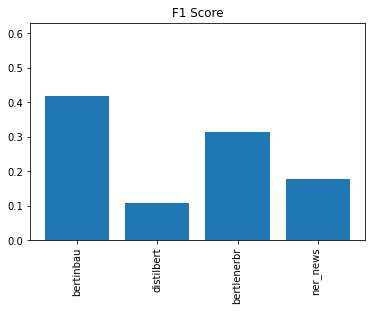

In [47]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.25217864923747274, 0.003110419906687403, 0.14984297891431134, 0.10415035238841033]


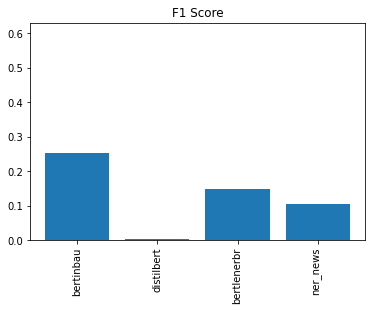

In [48]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.46840958605664484, 0.16085314374583426, 0.3454463885150291, 0.21456538762725136]


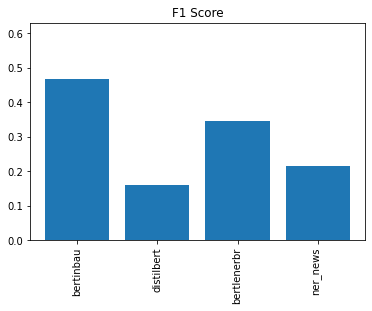

In [49]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['ent_type']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.298474945533769, 0.004443457009553433, 0.1969493046209062, 0.10415035238841033]


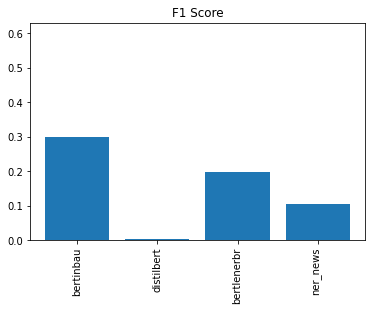

In [50]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['exact']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()

### Teste 2:

In [51]:
def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    # else: # fixing extractions with wrong ponctuations
    #     splits = ent.split(' ')
    #     try: # finding end
    #         while not _are_all_splits_in(text[span['start']:span['end']], splits):
    #             span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
    #     except ValueError: pass
    #     try: # find start
    #         while _are_all_splits_in(text[span['start']:span['end']], splits):
    #             span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
    #     except ValueError: pass
    if(span['start']==0 and span['end']==0):
        print('\t', text, '\n\t\t',"ERROU em:  =>  ", ent, '\n\t\t')
    else:
        print('\t', text, '\n\t\t', ent, '\n\t\t', text[span['start']:span['end']])
        return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

entity_to_span('I use it mostly for content creation (Audio, video, photo editing) and its reliable.', ['content creation Audio', 'POS'])

	 I use it mostly for content creation (Audio, video, photo editing) and its reliable. 
		 ERROU em:  =>   content creation Audio 
		


In [52]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

A saída de streaming foi truncada nas últimas 5000 linhas.
		 33/2021
	 EXTRATO DO CONTRATO DE CONCESSÃO DE USO SOBRE ÁREA PÚBLICA DO DISTRITO FEDERAL Nº 33/2021 Processo: 00390-00004656/2020-99. PARTES: O DISTRITO FEDERAL, por meio da SECRETARIA DE ESTADO DE DESENVOLVIMENTO URBANO E HABITAÇÃO DO DISTRITO FEDERAL - SEDUH, com sede Setor Comercial Norte, Quadra 01, Bloco A - Edifício Number One - Asa Norte - Brasília/DF, CEP: 70711-900, Telefone: (61) 3214-4180, inscrita no CNPJ sob o nº 02.342.553/0001-58, doravante denominado CONCEDENTE, neste ato representado por MATEUS LEANDRO DE OLIVEIRA, brasileiro, casado, inscrito no CPF sob o nº 285.**0.2**-96, na qualidade de Secretário de Estado da Secretaria de Estado de Desenvolvimento Urbano e Habitação do Distrito Federal, com delegação de competência concedida por intermédio do Decreto nº 41.446, de 10 de novembro de 2020, e TELEFÔNICA BRASIL S.A., com sede social na Avenida Engenheiro Luiz Carlos Berrini, 1.376, Cidade Monções, São Paul

texto  \
0    Especie: Contrato no 128/2019-SES/DF. SIGGO: 4...   
1    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 117/2...   
2    EXTRATO DO CONTRATO DE CREDENCIAMENTO No 102/2...   
3    EXTRATO DO CONTRATO No 73/2019 AQUISICAO DE BE...   
4    EXTRATOS DE CONTRATOS CONTRATO No 9152. ASSINA...   
..                                                 ...   
188  EXTRATO DO CONTRATO Nº 45830/2022 Processo: 00...   
189  EXTRATO DO CONTRATO DE LOCAÇÃO DE IMÓVEL Nº 01...   
190  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   
191  EXTRATO DO CONTRATO DE EXECUÇÃO DE OBRAS PARA ...   
192  EXTRATO DO CONTRATO Nº 45.926/2022 Processo: 0...   

                                            annotation  \
0    [{'label': 'numero_contrato', 'start': 21, 'en...   
1    [{'label': 'partes_contratuais', 'start': 114,...   
2    [{'label': 'data_assinatura_contrato', 'start'...   
3    [{'label': 'partes_contratuais', 'start': 91, ...   
4    [{'label': 'data_assinatura_contrato', 'start'...   
..                                                 ...   
188  [{'label': 'numero_contrato', 'start': 23, 'en...   
189  [{'label': 'natureza_despesa', 'start': 1239, ...   
190  [{'label': 'partes_contratuais', 'start': 96, ...   
191  [{'label': 'partes_contratuais', 'start': 118,...   
192  [{'label': 'data_assinatura_contrato', 'start'...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 21, 'en...   
1    [{'label': 'numero_contrato', 'start': 41, 'en...   
2    [{'label': 'numero_contrato', 'start': 41, 'en...   
3    [{'label': 'numero_contrato', 'start': 23, 'en...   
4    [{'label': 'numero_contrato', 'start': 34, 'en...   
..                                                 ...   
188  [{'label': 'numero_contrato', 'start': 23, 'en...   
189  [{'label': 'partes_contratuais', 'start': 107,...   
190  [{'label': 'partes_contratuais', 'start': 96, ...   
191  [{'label': 'partes_contratuais', 'start': 57, ...   
192  [{'label': 'numero_contrato', 'start': 23, 'en...   

                                            distilbert  \
0    [{'label': 'objeto_contrato', 'start': 78, 'en...   
1    [{'label': 'partes_contratuais', 'start': 134,...   
2    [{'label': 'partes_contratuais', 'start': 140,...   
3    [{'label': 'partes_contratuais', 'start': 102,...   
4    [{'label': 'objeto_contrato', 'start': 135, 'e...   
..                                                 ...   
188  [{'label': 'partes_contratuais', 'start': 94, ...   
189  [{'label': 'partes_contratuais', 'start': 110,...   
190  [{'label': 'partes_contratuais', 'start': 108,...   
191  [{'label': 'objeto_contrato', 'start': 158, 'e...   
192  [{'label': 'objeto_contrato', 'start': 127, 'e...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 21, 'en...   
1    [{'label': 'numero_contrato', 'start': 41, 'en...   
2    [{'label': 'numero_contrato', 'start': 41, 'en...   
3    [{'label': 'numero_contrato', 'start': 23, 'en...   
4    [{'label': 'vigencia_contrato', 'start': 52, '...   
..                                                 ...   
188  [{'label': 'numero_contrato', 'start': 23, 'en...   
189  [{'label': 'numero_contrato', 'start': 44, 'en...   
190  [{'label': 'numero_contrato', 'start': 46, 'en...   
191  [{'label': 'partes_contratuais', 'start': 48, ...   
192  [{'label': 'numero_contrato', 'start': 23, 'en...   

                                              ner_news  
0    [{'label': 'partes_contratuais', 'start': 111,...  
1    [{'label': 'partes_contratuais', 'start': 114,...  
2                                                   []  
3                                                   []  
4    [{'label': 'partes_contratuais', 'start': 1217...  
..                                                 ...  
188  [{'label': 'partes_contratuais', 'start': 70, ...  
189  [{'label': 'partes_contratuais', 'start': 97, ...  
190  [{'label': 'partes_contratuais', 'start': 104,

In [53]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato']).evaluate()

In [54]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 603,
    'incorrect': 126,
    'partial': 0,
    'missed': 1390,
    'spurious': 344,
    'possible': 2119,
    'actual': 1073,
    'precision': 0.5619757688723206,
    'recall': 0.2845681925436527,
    'f1': 0.37781954887218044},
   'partial': {'correct': 454,
    'incorrect': 0,
    'partial': 275,
    'missed': 1390,
    'spurious': 344,
    'possible': 2119,
    'actual': 1073,
    'precision': 0.5512581547064306,
    'recall': 0.2791411042944785,
    'f1': 0.37061403508771934},
   'strict': {'correct': 369,
    'incorrect': 360,
    'partial': 0,
    'missed': 1390,
    'spurious': 344,
    'possible': 2119,
    'actual': 1073,
    'precision': 0.34389561975768873,
    'recall': 0.17413874469089194,
    'f1': 0.23120300751879702},
   'exact': {'correct': 454,
    'incorrect': 275,
    'partial': 0,
    'missed': 1390,
    'spurious': 344,
    'possible': 2119,
    'actual': 1073,
    'precision': 0.42311276794035413,
    'recall': 0.21425200

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.37061403508771934, 0.10741088180112571, 0.2953136622861393, 0.1339538648320518]


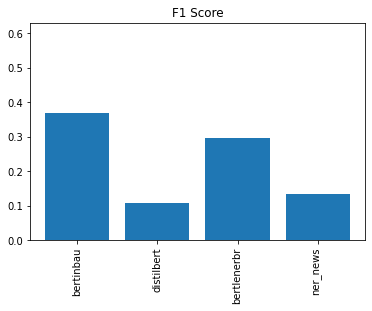

In [55]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.23120300751879702, 0.0018761726078799252, 0.13637490701710886, 0.06798866855524079]


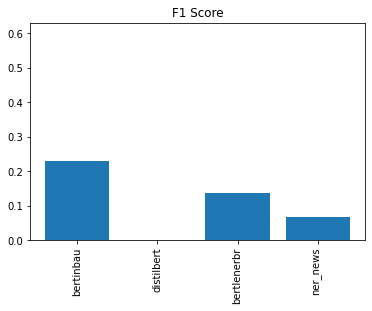

In [56]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.37781954887218044, 0.1599437148217636, 0.30349615670716584, 0.1659247268312424]


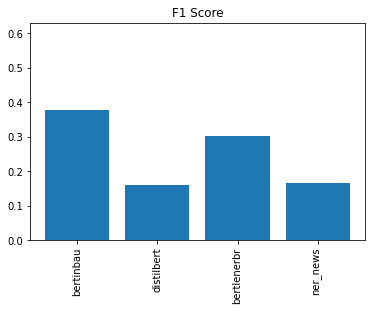

In [57]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['ent_type']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()

['bertinbau', 'distilbert', 'bertlenerbr', 'ner_news']
[0, 1, 2, 3]
[0.2844611528822055, 0.0032833020637898684, 0.18844532606000494, 0.06798866855524079]


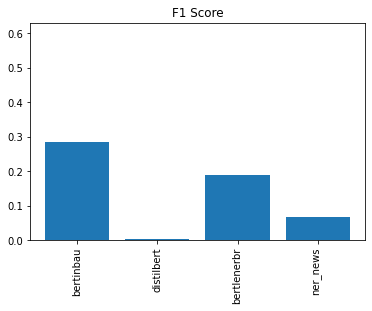

In [58]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['exact']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 0.63])
plt.title("F1 Score")
plt.show()